In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
from copy import deepcopy
from functools import partial

import optax
import numpy as np

from script_train import grid_train
from config import default_precorrector_config, default_edgemlp_config
from train import make_PreCorrector_rhsOnes, make_LightGNN, make_EdgeMLP
from utils import params_count

In [3]:
seed = 42
path = '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/'
folder = 'results_cases/check_why_test_loss_lower'

In [4]:
data_config = {
    'data_dir': path,
    'pde': 'div_k_grad',
    'grid': 128,
    'variance': .7,
    'lhs_type': 'l_ic0',
    'N_samples_train': 100,
    'N_samples_test': 200,
    'precision': 'f64',
    'fill_factor': 1,
    'threshold': 1e-4
}

train_config = {
    'loss_type': 'low_freq_loss',
    'model_type': 'precorrector_rhs_ones',
    'batch_size': 8,
    'optimizer': optax.adam,
    'lr': 1e-3,
    'optim_params': {},
    'epoch_num': 201
}

base_config = {
    'path': path,
    'folder': folder,
    'name': np.nan,
    'model_use': 'train',
    'save_model': False,
    'cg_maxiter': 10,
    'cg_atol': 1e-12,
    'data_config': data_config,
    'model_config': np.nan,
    'train_config': train_config,
    'seed': seed
}

In [5]:
# PreCorrector_NotStaticDiag (make_model, config)
precor_notstatic = (
    partial(make_PreCorrector_rhsOnes, static_diag=False),
    default_precorrector_config
)

In [6]:
# LightGNN_StaticDiag_NoNodeMLP (make_model, config)
lgnn_static_nonode = (
    partial(make_LightGNN, static_diag=True, node_mlp=False, edge_mlp=True),
    default_precorrector_config
)

In [7]:
# LightGNN_StaticDiag_NoNodeMLP_NoEdgeMLP (make_model, config)
lgnn_static_nonode_noedge = (
    partial(make_LightGNN, static_diag=True, node_mlp=False, edge_mlp=False),
    default_precorrector_config
)

In [8]:
# PreCorrector_aggregMin (make_model, config)
config_aggrmin = deepcopy(default_precorrector_config)
config_aggrmin['mp']['aggregate_edges'] = 'min'
precor_aggrmin = (
    partial(make_PreCorrector_rhsOnes, static_diag=True),
    config_aggrmin
)

In [9]:
# PreCorrector_aggregMax (make_model, config)
config_aggrmax = deepcopy(default_precorrector_config)
config_aggrmax['mp']['aggregate_edges'] = 'max'
precor_aggrmax = (
    partial(make_PreCorrector_rhsOnes, static_diag=True),
    config_aggrmax
)

In [10]:
# EdgeMLP_NotStaticDiag
edgemlp_notstatic = (
    partial(make_EdgeMLP, static_diag=False),
    default_edgemlp_config
)

In [11]:
# EdgeMLP_StaticDiag
edgemlp_static = (
    partial(make_EdgeMLP, static_diag=True),
    default_edgemlp_config
)

In [12]:
runs_dict = {
    'EdgeMLP_StaticDiag': edgemlp_static,
#     'EdgeMLP_NotStaticDiag': edgemlp_notstatic
#     'PreCorrector_NotStaticDiag': precor_notstatic,
#     'LightGNN_StaticDiag_NoNodeMLP': lgnn_static_nonode,
#     'LightGNN_StaticDiag_NoNodeMLP_NoEdgeMLP': lgnn_static_nonode_noedge,
#     'PreCorrector_aggregMin': precor_aggrmin,
#     'PreCorrector_aggregMax': precor_aggrmax
}

## Exmperiments function

In [13]:
import os
import getpass
import logging
from copy import deepcopy
from time import perf_counter

import optax
from jax import random, vmap, numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

from data.dataset import load_dataset
from data.graph_utils import spmatrix_to_graph
from config import default_precorrector_config
from scipy_linsolve import make_Chol_prec_from_bcoo, batched_cg_scipy
from train import construction_time_with_gnn, train_inference_finetune
from train import make_PreCorrector_rhsOnes, make_PreCorrector, make_NaiveGNN
from utils import id_generator

In [14]:
def run(config, name, run_spec):
    # Setup
    key = random.PRNGKey(config['seed'])
    config['name'] = name
    config['model_config'] = run_spec[1]
    
    data_config = config['data_config']
    model_config = config['model_config']
    train_config = config['train_config']
    
    make_model = run_spec[0]
    base_dir = os.path.join(config['path'], config['folder'], config['name'])
    try: os.mkdir(base_dir)
    except: pass
    
    # Logging
    model_file = os.path.join(base_dir, config['name']+'.eqx')
    log_file = os.path.join(base_dir, config['name']+'.log')
    loss_file = os.path.join(base_dir, 'losses_'+config['name']+'.npz')
    
    logging.basicConfig(
        level = logging.INFO,
        format = '[%(levelname)s | ' + getpass.getuser() + ' | %(asctime)s] - %(message)s',
        force = True,
        datefmt = "%Y-%m-%d %H:%M:%S",
        handlers = [logging.FileHandler(log_file, "a", "utf-8"),
                    logging.StreamHandler()]
    )
    logging.captureWarnings(True)
    logging.info('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    logging.info(f'Script with model `{config["name"]}` started execution.')    
    logging.info('Config: %s.\n', config)
    
    try:
        results_folder_exists = os.path.isdir(os.path.join(config['path'], config['folder']))
        data_dir_exists = os.path.isdir(data_config['data_dir'])
        assert os.path.isdir(config['path']) and results_folder_exists and data_dir_exists, 'Check directories'
    except Exception as e:
        logging.critical(e)
        return False
    
    # Data loading
    try:
        s = perf_counter()
        train_set = load_dataset(data_config, return_train=True)
        A_train, A_pad_train, b_train, bi_edges_train, x_train, class_time_mean_train, class_time_std_train = train_set

        test_set = load_dataset(data_config, return_train=False)
        A_test, A_pad_test, b_test, bi_edges_test, x_test, class_time_mean_test, class_time_std_test = test_set
        
        data = (
            [A_train, A_pad_train, b_train, bi_edges_train, x_train],
            [A_test, A_pad_test, b_test, bi_edges_test, x_test]
        )
        data_time = perf_counter() - s
        logging.info(f'Data is loaded in {data_time:.3e} sec.\n')
    except Exception as e:
        logging.critical(f'Script failed on data loading.\n{e}\n\n\n')
        return False
        
    # Model training
    try:
        s = perf_counter()
        model, losses, _ = train_inference_finetune(key, data, make_model, model_config,
                                                    train_config, model_path=model_file,
                                                    model_use=config['model_use'], save_model=config['save_model'])
        training_time = perf_counter() - s
        if train_config['model_type'] != 'naivegnn':
            alpha = f'{model.alpha.item():.4f}' 
        else:
            alpha = '-'


        logging.info(f'Model is trained in {training_time:.3e} sec.')
        logging.info(f"GNN's alpha = {alpha}.")
        logging.info(f'First and last losses: train = [{losses[0][0]:.3e}, {losses[0][-1]:.3e}], test = [{losses[1][0]:.3e}, {losses[1][-1]:.3e}].\n')
        jnp.savez(loss_file, train_loss=losses[0], test_loss=losses[1])
    except Exception as e:
        logging.critical(f'Script failed on model training.\n{e}\n\n\n')
        return False
    
    # Preconditioner construction
    try:
        time_gnn_mean, time_gnn_std = construction_time_with_gnn(model, A_test[0, ...], A_pad_test[0, ...], b_test[0, ...],
                                                                 bi_edges_test[0, ...], num_rounds=A_test.shape[0],
                                                                 pre_time_ic=class_time_mean_test)
        L = vmap(model, in_axes=(0), out_axes=(0))(spmatrix_to_graph(A_pad_test, b_test))
        P = make_Chol_prec_from_bcoo(L)
        P_class = make_Chol_prec_from_bcoo(A_pad_test)

        logging.info(f'Precs are combined:')
        logging.info(f' classical prec construction time (sec) : mean = {class_time_mean_test:.3e}, std = {class_time_std_test:.3e};')
        logging.info(f' GNN prec construction time (sec) : mean = {time_gnn_mean:.3e}, std = {time_gnn_std:.3e}.\n')
    except Exception as e:
        logging.critical(f'Script failed on precs combination.\n{e}\n\n\n')
        return False
        
    # CG with PreCorrector's prec
    try:
        iters_stats, time_stats, nan_flag = batched_cg_scipy(A_test, b_test, time_gnn_mean, 'random',
                                                             key, P, config['cg_atol'],
                                                             config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])
        logging.info('CG with GNN is finished:')
        logging.info(f' iterations to atol([mean, std]): %s;', iters_stats)
        logging.info(f' time to atol([mean, std]): %s;', time_stats)
        logging.info(f' number of linsystems for which CG did not conerge to atol: %s.\n', nan_flag)
    except Exception as e:
        logging.critical(f'Script failed on CG with GNN.\n{e}\n\n\n')
        return False
        
    # CG with classical prec
    try:
        iters_stats_class, time_stats_class, nan_flag_class = batched_cg_scipy(A_test, b_test, class_time_mean_test, 'random',
                                                                               key, P_class, config['cg_atol'],
                                                                               config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])
        logging.info('CG with classical prec is finished:')
        logging.info(f' iterations to atol([mean, std]): %s;', iters_stats_class)
        logging.info(f' time to atol([mean, std]): %s;', time_stats_class)
        logging.info(f' number of linsystems for which CG did not conerge to atol: %s.\n', nan_flag_class)
    except Exception as e:
        logging.critical(f'Script failed on CG with classical prec.\n{e}\n\n\n')
        return False
        
    logging.info(f'Script with model `{config["name"]}` finished execution.\n\n\n')
    return model

In [15]:
for k, v in runs_dict.items():
    model = run(base_config, k, v)

2025-01-20 18:59:08.891856: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
[INFO | root | 2025-01-20 18:59:09] - %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[INFO | root | 2025-01-20 18:59:09] - Script with model `EdgeMLP_StaticDiag` started execution.
[INFO | root | 2025-01-20 18:59:09] - Config: {'path': '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/', 'folder': 'results_cases/check_why_test_loss_lower', 'name': 'EdgeMLP_StaticDiag', 'model_use': 'train', 'save_model': False, 'cg_maxiter': 10, 'cg_atol': 1e-12, 'data_config': {'data_dir': '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/', 'pde': 'div_k_grad', 'grid': 128, 'variance

In [16]:
params_count(model)

50

In [17]:
name = 'EdgeMLP_StaticDiag'

28948.705


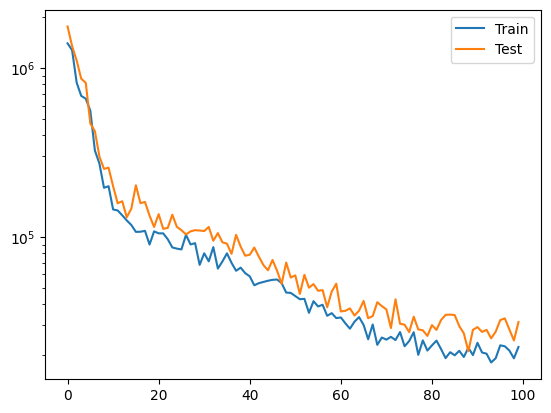

In [18]:
f = np.load(os.path.join(path, folder, name, 'losses_'+name+'.npz'))
plt.plot(range(f['train_loss'][:100].shape[0]), f['train_loss'][:100], label='Train')
plt.plot(range(f['test_loss'][:100].shape[0]), f['test_loss'][:100], label='Test')
plt.yscale('log')
plt.legend()

print(f['test_loss'][-1])